Importar librerías y montar el drive

In [1]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Cargar y adecuar los datos

Descargar y descomprimir los archivos

In [3]:
!wget --no-check-certificate \
   https://www.dropbox.com/s/0j7s080efbfh8gc/cats_and_dogs_small.zip?dl=0\
   -O cats_and_dogs_small.zip

local_zip = 'cats_and_dogs_small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

--2022-11-14 19:19:43--  https://www.dropbox.com/s/0j7s080efbfh8gc/cats_and_dogs_small.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/0j7s080efbfh8gc/cats_and_dogs_small.zip [following]
--2022-11-14 19:19:44--  https://www.dropbox.com/s/raw/0j7s080efbfh8gc/cats_and_dogs_small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc919311b41bc0aa6b9b56ee5362.dl.dropboxusercontent.com/cd/0/inline/BwzZAIcNQSLniBVYYkdQZs2kTk0zG84tB-WypT9RhR1CrxNu1ky6dyF7qcxM30zBVDXX1-Yp2KZ277esrk26yV-GxmqiH9KIGmeCdiXAkFLfk7R9dVR9xLVOaAekM0oOb0oXcF-y-tXzoD35iyWrqM-kjAtMklhKt2hdKFeQL7EHwg/file# [following]
--2022-11-14 19:19:44--  https://uc919311b41bc0aa6b9b56ee5362.dl.dropboxusercontent.com/cd/0/inline/BwzZAIcNQSLniBVYYkdQZs2kTk0zG84tB-WypT9

Configurar y dividir dataset

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

path = '/content/cats_and_dogs_small'

# Nuevas dimensiones para las imágenes
height = 150
width = 150

# Crear el dataset a partir del directorio
dataset = image_dataset_from_directory(directory=path, label_mode='int', class_names=['dogs','cats'], batch_size=None, image_size=(height,width))

Found 4000 files belonging to 2 classes.


Colocar todos los datos en arreglos

In [5]:
# En estas listas se guardaran los datos
imagenes = []
etiquetas = []

for (imagen, etiqueta) in dataset:
  imagenes.append(imagen)
  etiquetas.append(etiqueta)

# Convertir listas en arreglos
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)

In [6]:
# Contar cuántos elementos hay para cada clase
clase1 = 0
clase2 = 0

for n in range(len(etiquetas)):
  if etiquetas[n]==0:
    clase1 +=1
  elif etiquetas[n]==1:
    clase2 += 1

print('La clase 1 posee ', clase1, ' elementos')
print('La clase 2 posee ', clase2, ' elementos')

if clase1==clase2:
  print('Las clases están balanceadas')

La clase 1 posee  2000  elementos
La clase 2 posee  2000  elementos
Las clases están balanceadas


Crear conjunto de entrenamiento, validación y test

In [7]:
from sklearn.model_selection import train_test_split

# Dividir el conjunto de datos
xtrain, xval, ytrain, yval = train_test_split(imagenes, etiquetas, train_size=0.6, random_state=13)
xval, xtest, yval, ytest = train_test_split(xval, yval, train_size = 0.5, random_state=13)

# Mostrar el tamaño de cada conjunto
print('Tamaño de los Datos')
print('Entrenamiento: \n', xtrain.shape, ytrain.shape)
print('Validación: \n', xval.shape, yval.shape)
print('Test: \n', xtest.shape, ytest.shape)

Tamaño de los Datos
Entrenamiento: 
 (2400, 150, 150, 3) (2400,)
Validación: 
 (800, 150, 150, 3) (800,)
Test: 
 (800, 150, 150, 3) (800,)


Normalizar

In [8]:
# Función para normalizar imágenes
def preproceso(imagen):
  img = imagen/255.0
  return img

# Resize y normalización de las imágenes
xtrain = np.array(list(map(preproceso, xtrain)))
xval = np.array(list(map(preproceso, xval)))
xtest = np.array(list(map(preproceso, xtest)))

Visualizar algunos ejemplos del dataset

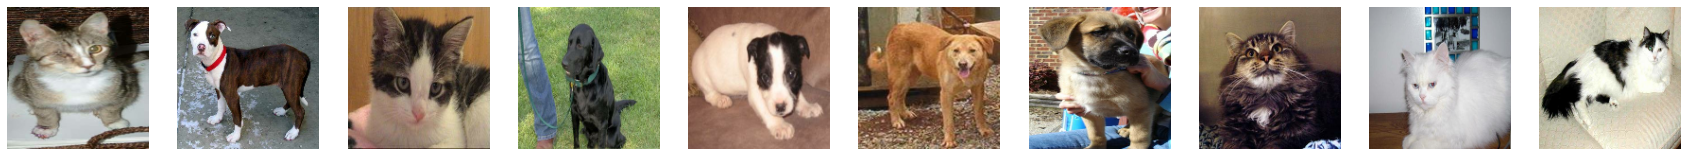

In [9]:
plt.figure(figsize=(30,20))

for index, (imagen, etiqueta) in enumerate(zip(xtrain[0:10], ytrain[0:10])):
  plt.subplot(1, 10, index+1)
  plt.imshow(imagen)
  plt.axis('off')

Codificación One Hot

In [10]:
# from tensorflow.keras.utils import to_categorical

# ytrain = to_categorical(ytrain, 2)
# yval = to_categorical(yval, 2)
# ytest = to_categorical(ytest, 2)

# print(ytrain[0])

## Clasificador con AutoKeras

Instalar AutoKeras

In [11]:
!pip install autokeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 13.7 MB/s 
     |████████████████████████████████| 135 kB 72.2 MB/s 
     |████████████████████████████████| 1.6 MB 80.0 MB/s 


In [12]:
import autokeras as ak

# Buscar un buen modelo para clasificar el dataset (se probará con 5)
automodel = ak.ImageClassifier(overwrite=True, max_trials=5)
# Entrenar el mejor modelo
automodel.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=3)

Trial 5 Complete [00h 05m 21s]
val_loss: 0.5040158033370972

Best val_loss So Far: 0.10266803950071335
Total elapsed time: 00h 26m 10s


Epoch 1/3


75/75 [==============================] - 122s 1s/step - loss: 0.5234 - accuracy: 0.7883 - val_loss: 0.6906 - val_accuracy: 0.5325
Epoch 2/3
75/75 [==============================] - 88s 1s/step - loss: 0.2746 - accuracy: 0.9267 - val_loss: 0.5476 - val_accuracy: 0.7412
Epoch 3/3
75/75 [==============================] - 88s 1s/step - loss: 0.1534 - accuracy: 0.9608 - val_loss: 0.3149 - val_accuracy: 0.8888


### Predicciones del Modelo

In [13]:
# Predicción
auto_pred = automodel.predict(xtest)

25/25 [==============================] - 5s 201ms/step


In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

ypredtest = to_categorical(ytest, 2)
reporte = classification_report(np.argmax(ypredtest, axis=1), auto_pred, target_names=['dog','cat'])
print(reporte)

              precision    recall  f1-score   support

         dog       0.94      0.81      0.87       393
         cat       0.84      0.95      0.89       407

    accuracy                           0.88       800
   macro avg       0.89      0.88      0.88       800
weighted avg       0.89      0.88      0.88       800



## Clasificador con KerasTuner

In [15]:
!pip install -q -U keras-tuner

In [16]:
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Conv2D, Dense, Flatten

def build_model(hp):
  model = Sequential()
  
  # Número de filtros en primera capa convolucional y tamaño de kernel
  filters1 = hp.Int('conv_1_filter', min_value=10, max_value=128, step=16)
  kernel1 = hp.Choice('conv_1_kernel', values = [3,5])
  model.add(Conv2D(filters1, kernel_size=kernel1, activation='relu',  input_shape=(150,150,3)))
  model.add(AveragePooling2D(pool_size=(2,2)))
  # Número de filtros en segunda convolución y tamaño de kernel
  filters2 = hp.Int('conv_2_filter', min_value=20, max_value=128, step=16)
  kernel2 = hp.Choice('conv_2_kernel', values = [3,5])
  model.add(Conv2D(filters2, kernel_size=kernel2, activation='relu'))
  model.add(AveragePooling2D(pool_size=(2,2)))
  # Número de filtros tercera convolución y tamaño de kernel
  filters3 = hp.Int('conv_3_filter', min_value=30, max_value=128, step=16)
  kernel3 = hp.Choice('conv_3_kernel', values = [3,5])
  model.add(Conv2D(filters3, kernel_size=kernel3, activation='relu'))
  model.add(AveragePooling2D(pool_size=(2,2)))

  model.add(Flatten())

  # Cantidad de neuronas en primera capa densa
  units1 = hp.Int('dense_1_units', min_value=32, max_value=128, step=16)
  model.add(Dense(units=units1, activation='relu'))
  # Cantidad de neuronas en segunda capa densa
  units2 = hp.Int('dense_2_units', min_value=32, max_value=128, step=16)
  model.add(Dense(units=units2, activation='relu'))
  # Capa de salida
  model.add(Dense(units=2, activation='softmax'))

  #Compilación del modelo
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-4])), loss='categorical_crossentropy', metrics=['accuracy'])

  return model


Inicializar el 'tuner'

In [17]:
tuner = keras_tuner.RandomSearch(build_model, objective='val_accuracy', max_trials=5)

Codificación One Hot antes de comenzar la búsqueda

In [18]:
from tensorflow.keras.utils import to_categorical

ytrain = to_categorical(ytrain, 2)
yval = to_categorical(yval, 2)
ytest = to_categorical(ytest, 2)

Comenzar la búsqueda de los mejores hiperparámetros para el modelo

In [19]:
tuner.search(xtrain, ytrain, epochs=5, validation_data=(xval, yval))

tunermodel = tuner.get_best_models()[0]

Trial 5 Complete [00h 00m 10s]
val_accuracy: 0.512499988079071

Best val_accuracy So Far: 0.6487500071525574
Total elapsed time: 00h 01m 20s


### Predicciones del Modelo

In [20]:
from sklearn.metrics import classification_report

# Predecir con el modelo
pred = tunermodel.predict(xtest)
# Devolver la posición del valor más alto de cada predicción (ya que está en One Hot)
pred = np.argmax(pred, axis = 1) 

reporte_RedPersonal = classification_report(np.argmax(ytest, axis=1), pred, target_names=['dog','cat'])
print(reporte_RedPersonal)

25/25 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

         dog       0.65      0.51      0.58       393
         cat       0.61      0.74      0.67       407

    accuracy                           0.63       800
   macro avg       0.63      0.63      0.62       800
weighted avg       0.63      0.63      0.62       800

